In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Loading and examining the dataset

In [2]:
penguins_df = pd.read_csv("data/penguins.csv")
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


### Removing the null values

In [3]:
penguins_clean = penguins_df.dropna(subset=["body_mass_g", "sex"])
penguins_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   335 non-null    float64
 1   culmen_depth_mm    335 non-null    float64
 2   flipper_length_mm  335 non-null    float64
 3   body_mass_g        335 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 15.7+ KB


### Investigating the outliers

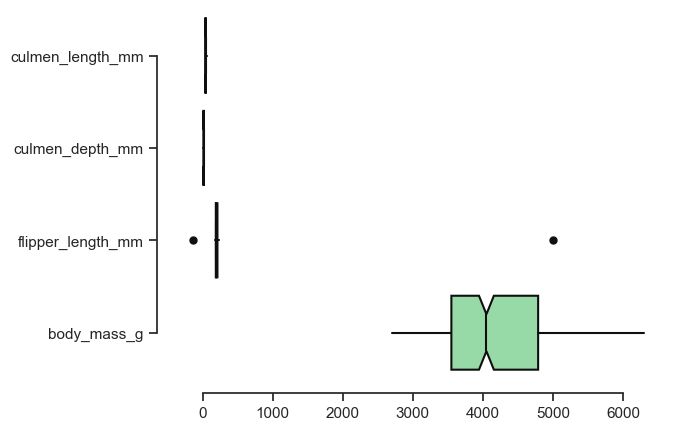

In [4]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(palette=["k", "g"],
    data=penguins_clean,
    notch=True, showcaps=False,
    flierprops={"marker": "o"},
    orient="h"
)
sns.despine(offset=10, trim=True)
plt.show()

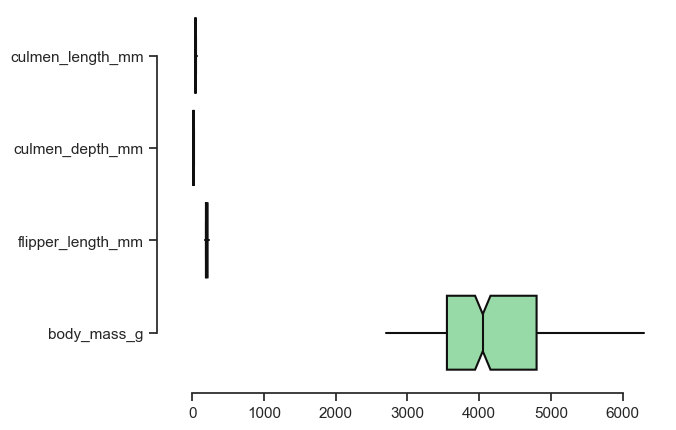

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   333 non-null    float64
 1   culmen_depth_mm    333 non-null    float64
 2   flipper_length_mm  333 non-null    float64
 3   body_mass_g        333 non-null    float64
 4   sex                333 non-null    object 
dtypes: float64(4), object(1)
memory usage: 15.6+ KB


In [5]:
# Removing the outliers
Q1 = penguins_clean['flipper_length_mm'].quantile(0.25)
Q3 = penguins_clean['flipper_length_mm'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5 * IQR
upper_bound= Q3 + 1.5 * IQR

rows_nums = penguins_clean[(penguins_clean['flipper_length_mm'] < lower_bound) | 
                           (penguins_clean['flipper_length_mm'] > upper_bound)].index

penguins_clean = penguins_clean.drop(rows_nums)

sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(palette=["k", "g"],
    data=penguins_clean,
    notch=True, showcaps=False,
    flierprops={"marker": "o"},
    orient="h"
)
sns.despine(offset=10, trim=True)
plt.show()

penguins_clean.info()

### Converting categorical feature into binary

In [6]:
# Creating the dummy variables and removing the original categorical feature from the dataset
df = pd.get_dummies(penguins_clean).drop("sex_.", axis=1)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
4,36.7,19.3,193.0,3450.0,1,0
5,39.3,20.6,190.0,3650.0,0,1


### Data scaling

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(df)
penguins_preprocessed = pd.DataFrame(data=X, columns=df.columns)
penguins_preprocessed.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,-0.905520,0.793126,-1.428125,-0.569709,-0.991031,0.997001
1,-0.831938,0.128503,-1.071522,-0.507579,1.009050,-1.003008
2,-0.684775,0.435252,-0.429637,-1.191006,1.009050,-1.003008
3,-1.347011,1.099875,-0.572278,-0.942487,1.009050,-1.003008
4,-0.868729,1.764498,-0.786240,-0.693968,-0.991031,0.997001


### Determining the number of PCA components

In [8]:
# Determining the desired number of PCA components, considering any component with an explained variance ratio above 10%
pca = PCA()
penguins_PCA = pca.fit(penguins_preprocessed)
n_components = sum(penguins_PCA.explained_variance_ratio_ > 0.1)
print(f"Number of PCA components: {n_components}")

pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)

Number of PCA components: 2


### Determing the number of clusters

1997.9999999999995
1217.197340245893
698.49621099145
388.8425767342261
292.92162846992096
221.03743948862467


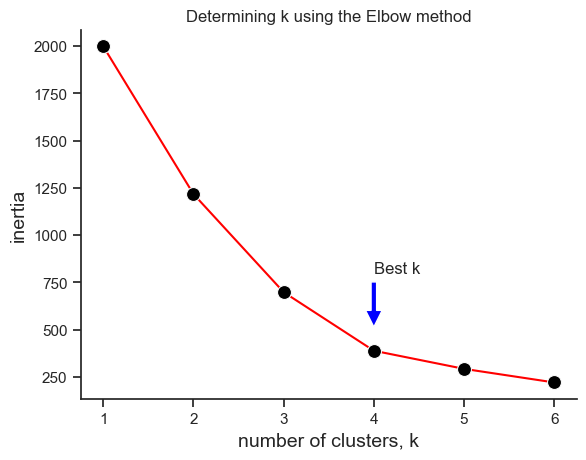

In [9]:
ks = range(1, 7)
inertia = []

for k in ks:  
    kmeans = KMeans(n_clusters=k, random_state=42).fit(penguins_preprocessed)
    print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
    
# Plot ks vs inertias
g = sns.lineplot(x=ks, y=inertia, marker="o", c="red", markersize=10, markerfacecolor='black')

sns.despine(right=True, top=True)
g.set_xlabel("number of clusters, k", fontsize=14)
g.set_ylabel("inertia", fontsize=14)
g.set_title("Determining k using the Elbow method")
g.set_xticks(ks)

g.annotate('Best k', xy=(4, 500), xytext=(4, 800),
            arrowprops=dict(facecolor='blue', shrink=0.05),
            )

plt.show()

n_clusters = 4

### Visualising the clusters using the first two principle components

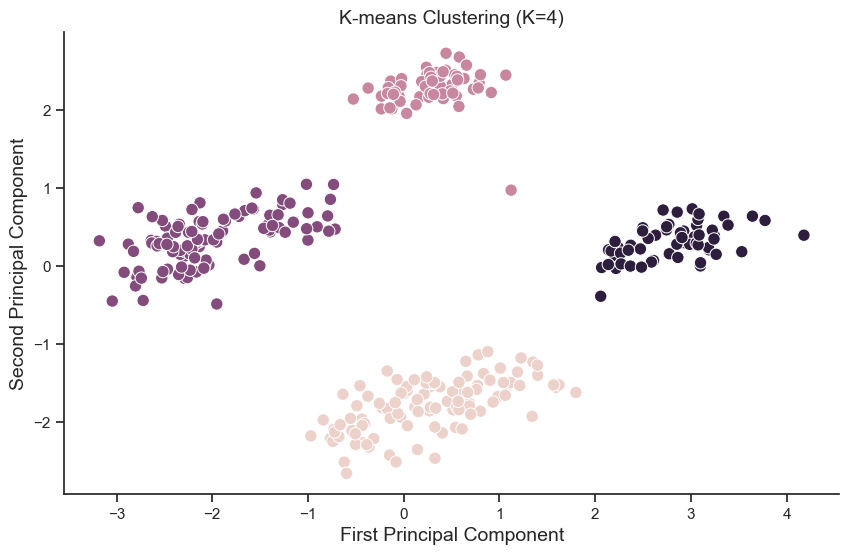

In [10]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)

g = plt.figure(figsize=(10,6))
g = sns.scatterplot(x=penguins_PCA[:, 0], y=penguins_PCA[:, 1], hue=kmeans.labels_, s=80, legend=None)
sns.despine(right=True, top=True)
g.set_xlabel("First Principal Component", fontsize=14)
g.set_ylabel("Second Principal Component", fontsize=14)
plt.title(f"K-means Clustering (K={n_clusters})", fontsize=14)

plt.show()

In [11]:
penguins_clean['label']= kmeans.labels_
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'label']
stat_penguins = penguins_clean[numeric_columns].groupby('label').mean()

stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0,43.878302,19.111321,194.764151,4006.603774
1,45.545763,14.262712,212.779661,4683.050847
2,40.217757,17.611215,189.046729,3419.158879
3,49.473770,15.718033,221.540984,5484.836066
